<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/3_20211005_KoGPT2_idiom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **⦁ GPT** 구조

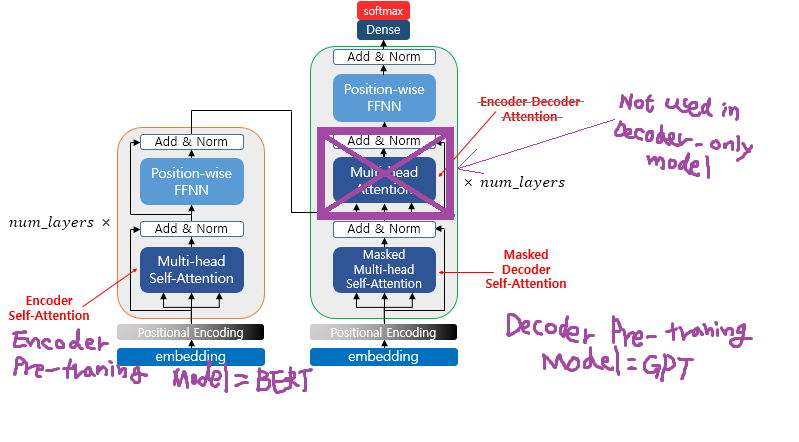

<br/><br/>

# **KoGPT2를 이용한 감성분석**
<br/>


### 1. 라이브러리 설치 및 임포트

In [3]:
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

     |████████████████████████████████| 344 kB 9.7 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595722 sha256=8de45a4c5ece35a704be1424bdd9de81a0b8c5dd155bd73152a36e37e7172a1a
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 2.9 MB 8.3 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 64.9 MB/s 
     |████████████████████████████████| 636 kB 80.9 MB/s 
     |████████████████████████████████| 3.3 MB 66.9 MB/s 
     |████████████████████████████████| 109 kB 74.6 MB/s 
     |████████████████████████████████| 546 kB 80.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 7.1 MB/s 


In [11]:
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


<br/><br/>
### 2. pickle을 이용해 final_idiom_dataset_for_ko.pkl 읽어오기 및 변수에 담기

In [25]:
import pickle
with open('1/train_11710.pkl', 'rb') as f:
  text = pickle.load(f)


In [27]:
type(text)

pandas.core.frame.DataFrame

In [28]:
text.head()

,ko,Label
0,그 노력이 말뿐인지 아닌지 두고 봐야 한다.,1
1,“가수가 연애한다고 퇴출까지 하는 것은 너무하다”는 부정적인 반응이 일각에서 나오자...,0
2,남북 경제협력을 염두에 둔 것이라지만 해외는 안 되는데 북한은 된다는 것은 앞뒤가 ...,1
3,더 이상 고발자들이 힘겹게 본인의 이야기를 꺼내지 않을 수 있도록 정부가 먼저 전수...,1
4,경찰은 문제의 앱이 ‘폴-안티스파이’인 것처럼 위장해 기기 정보와 개인 정보를 빼가...,0


In [29]:
data = text['ko']
data.head()

0                             그 노력이 말뿐인지 아닌지 두고 봐야 한다.
1    “가수가 연애한다고 퇴출까지 하는 것은 너무하다”는 부정적인 반응이 일각에서 나오자...
2    남북 경제협력을 염두에 둔 것이라지만 해외는 안 되는데 북한은 된다는 것은 앞뒤가 ...
3    더 이상 고발자들이 힘겹게 본인의 이야기를 꺼내지 않을 수 있도록 정부가 먼저 전수...
4    경찰은 문제의 앱이 ‘폴-안티스파이’인 것처럼 위장해 기기 정보와 개인 정보를 빼가...
Name: ko, dtype: object

In [30]:
target = text['Label']
target.head()

0    1
1    0
2    1
3    1
4    0
Name: Label, dtype: int64

<br/><br/>
### pre-training 데이터


In [31]:
dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")


In [32]:
MAX_LEN = 60
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [33]:
x_train, y_train = build_data(dx_train, dy_train)
x_test, y_test = build_data(dx_test, dy_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((9368, 62), (9368, 1), (2342, 62), (2342, 1))

In [34]:
x_test[0]


array([    0,   233,   131, 26474,   169,  1055, 35562,  1803,  3282,
        6163,   147,  3020,  7657, 47438,  9740,  9102,  3834,   908,
        4509,   350, 47440,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     3,     3,
           3,     3,     3,     3,     3,     3,     3,     1])

In [35]:
len(x_test[0])

62

In [36]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [37]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]


'▁전세'

In [38]:
# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

['<s>', '▁매', '▁주', '▁성당', '▁미', '사에', '▁나가지', '▁않는다', '해도', '▁그들의', '▁일', '상은', '▁가톨릭', '이', '▁몸에', '▁밴', '▁종교', '인이', '▁확실', '하다', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


In [39]:
gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [40]:
#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = True
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________


In [41]:
# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)


In [42]:
# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [43]:
# Downstream task : idiom classifier
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 2e-5))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 124,292,433
Non-trainable params: 0
_________________________________________________________________


In [45]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
147/147 [==============================] - 88s 597ms/step - loss: 0.6746 - val_loss: 0.6185
Epoch 2/3
147/147 [==============================] - 86s 582ms/step - loss: 0.4475 - val_loss: 0.2994
Epoch 3/3
147/147 [==============================] - 86s 582ms/step - loss: 0.2394 - val_loss: 0.2165


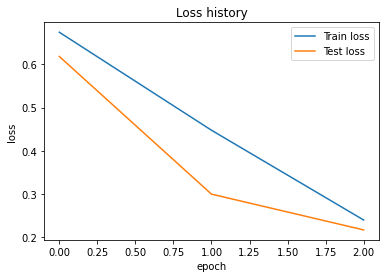

In [46]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [47]:
gpt_model.trainable = False
gpt_model.summary()

Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [48]:
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-6))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model (TFGPT2 TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________


In [49]:
x_train

array([[    0, 28601,  2993, ...,     3,     3,     1],
       [    0,  3868, 47690, ...,     3,     3,     1],
       [    0,  7112,   162, ...,     3,     3,     1],
       ...,
       [    0,   783,  4447, ..., 24155, 47440,     1],
       [    0,   167, 47531, ...,     3,     3,     1],
       [    0,  7472,  2805, ...,     3,     3,     1]])

In [50]:
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
147/147 [==============================] - 46s 245ms/step - loss: 0.1657 - val_loss: 0.2108
Epoch 2/3
147/147 [==============================] - 34s 231ms/step - loss: 0.1679 - val_loss: 0.2116
Epoch 3/3
147/147 [==============================] - 34s 231ms/step - loss: 0.1639 - val_loss: 0.2150


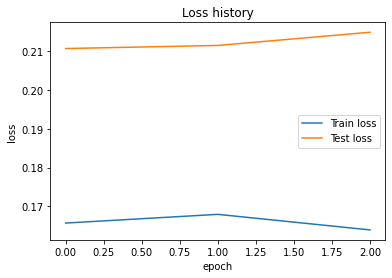

In [51]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [52]:
"""from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
# 정확도
print("accuracy:", accuracy_score(y_test, y_pred))

# 정밀도
print("precision:", precision_score(y_test, y_pred))

# 재현율
print("recall:", recall_score(y_test, y_pred))

# f1-score
print("F1-Score:", f1_score(y_test, y_pred))"""

'from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix\n# 오차행렬\n# 정확도\nprint("accuracy:", accuracy_score(y_test, y_pred))\n\n# 정밀도\nprint("precision:", precision_score(y_test, y_pred))\n\n# 재현율\nprint("recall:", recall_score(y_test, y_pred))\n\n# f1-score\nprint("F1-Score:", f1_score(y_test, y_pred))'

In [55]:
# 새로운 문장으로 테스트
#new_test = pd.read_csv('./idiom_dataset(18808).csv')
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data
f = open('KCC940_Korean_sentences_UTF8_V2.txt', 'r')
test = f.readlines()
test

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


['뒤이어 자유한국당, 바른정당 순이었고, 국민의당과 정의당이 각각 4%, 없음·의견유보 28%로 조사됐다.\n',
 '다만 포럼을 중심으로 신당 창당도 가능하냐는 질문엔 "보수우파를 분열케 하는 행동은 바람직하지 않다"고 일축했다.\n',
 '추미애 더불어민주당 대표는 "다른 건 다 좋아요. 그런데 제헌절에 유감이 있다는 대표는 뭐예요?"라고 물었다.\n',
 '그는 "지역 유권자들이 자유한국당은 지구 상에 이런 야당은 유일할 거다, 희귀하고 기괴한 야당이라고 한다"며 "어떤 나라의 야당도 민족의 이익이나 국가의 이익과 결부된 사안에 대해서는 힘을 모으지 않나. 자유한국당은 오로지 지방선거에서 어떻게 돌파구를 찾을 것인가 여기에만 관심이 있다"고 지적했다.\n',
 '이 위원장은 최우선 과제로 청년 취업난 해소를 꼽았다.\n',
 '다만 야당이 중재안을 받아들이는 걸 전제로 시간을 더 달라고 하면 하루 이틀 정부 이송을 늦출 순 있다고 한다.\n',
 '추 대표는 정치권 일각에서 \'문 전 대표를 이미 대선의 야권 후보로 본다\'는 주장에 " 김대중 전 대통령을 만나 입당원서를 쓰면서 정대철 전 고문에게 들은 \'정치는 생물\'이란 말이 생생하다"며 "경선도 안 했는데 확정이 어딨느냐"고 답했다.\n',
 '그러면서 "이 정부가 남북 평화쇼를 하고 있지만, 국민 불안은 가중되고 있다"고 덧붙였다.\n',
 '박 전 대통령은 검정색 에쿠스 차량에서 내리며 마중나온 임원주 사무국장에게 고개숙여 인사했다.\n',
 '정우택 의원 측은 이러한 조처가 아동학대 조기발견과 예방에 효과가 있을 것이라고 예상하고 있다.\n',
 '새누리당 정진석 원내대표와 김희옥 비대위원장이 7일 오전 서울 여의도 새누리당 당사에서 열린 혁신비상대책회의에 참석해 이야기를 나누고 있다.\n',
 '상왕십리 열차 추돌 사고 이후 시민 안전을 위해 기준이 강화됐는데, 전동차 제작 과정을 점검할 필요가 있다는 것이다.\n',
 '당시에는 중동호흡기증후군 확산으로 혼란이 가중되던 시기여서 최 의원

In [ ]:
#new_test['Label'] = 1

In [ ]:
new_test['ko'][10]

,ko,Label
0,예비역 장성 마크 허틀링은 트럼프 대통령이 구상한 방위비분담금 인상안에 대해 “그것...,0
1,실제 국토교통부 자료에 따르면 지난해 전국 단독주택 거래량은 16만2673건으로 정...,0
2,그런데 어느 누구도 이 안에서 다른 것을 듣지 않았어요.,1
3,"기압이 낮아지고 있어요, 모두 대피시켜야 해요.",0
4,당초 강 위원장은 국정감사에서 이 문제가 불거지자 “감사원 감사를 받겠다”며 버텼지...,1
...,...,...
2995,그럼 이 크림치즈 스파게티는 어떠세요?,0
2996,하지만 혹시 모르니 병원에 찾아가는 게 좋겠죠?,1
2997,"규정상 내려줄 수 없었다고 하는데 이렇게 사람 진 빠지게 하는 규정이 맞는 건지, ...",1
2998,첫 번째는 원외위원장들이 뼈 빠지게 하고 있기 때문이다.,1


In [59]:
new_test = pd.DataFrame(test, columns=['ko'])

In [60]:
new_test.head()

,ko
0,"뒤이어 자유한국당, 바른정당 순이었고, 국민의당과 정의당이 각각 4%, 없음·의견유..."
1,"다만 포럼을 중심으로 신당 창당도 가능하냐는 질문엔 ""보수우파를 분열케 하는 행동은..."
2,"추미애 더불어민주당 대표는 ""다른 건 다 좋아요. 그런데 제헌절에 유감이 있다는 대..."
3,"그는 ""지역 유권자들이 자유한국당은 지구 상에 이런 야당은 유일할 거다, 희귀하고 ..."
4,이 위원장은 최우선 과제로 청년 취업난 해소를 꼽았다.\n


In [61]:
new_test = new_test.sample(frac=1).reset_index(drop=True)
new_test

,ko
0,서울 서대문경찰서는 10일 만취 상태에서 60대 택시기사를 때려 의식불명에 빠트리게...
1,특히 지난해 편의점 신규 출점수는 4513개로 사상 최대를 기록했다.\n
2,성공적 투자에 있어서 가장 중요한 요소는 '양질의 기업'을 발굴해 장기투자하는 것이...
3,일직선으로 뻗은 예천의 낙동강 둑길을 달린 자전거길은 상주 상풍교에서 새재자전거길을...
4,다양하게 형태가 바뀌기 때문에 식용유나 버터 대신 조리할 때 사용할 수도 있고 기름...
...,...
6263449,9일 BBC방송 등에 따르면 이란 정책의 최종 결정권자인 아야톨라 알리 하메네이 최...
6263450,때로는 공개적인 언급을 통해 파급이 확산되는 것을 효과적으로 눌렀다.\n
6263451,17일 청와대 국민청원 게시판에 올라온 청원글에 따르면 지난달 30일 동아대 수학과...
6263452,영국 일간 텔레그래프는 이날 제프 블라터 전 FIFA 회장이 2010년 남아공 월드...


In [62]:
def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

In [ ]:
new_test_text, _ = build_data(new_test['ko'], np.zeros(len(new_test)))
answer = new_test.Label.to_list()
len(answer)
# 시험 데이터로 학습 성능을 평가한다
new_pred = model.predict(new_test_text)
new_y_pred = np.where(new_pred > 0.5, 1, 0)
#new_accuracy = (new_y_pred == answer).mean()
#print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

In [ ]:
new_y_pred.sum()

1504

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬

# 정확도
print("accuracy:", accuracy_score(answer, new_y_pred))

# 정밀도
print("precision:", precision_score(answer, new_y_pred))

# 재현율
print("recall:", recall_score(answer, new_y_pred))

# f1-score
print("F1-Score:", f1_score(answer, new_y_pred))

accuracy: 0.934
precision: 0.932845744680851
recall: 0.9353333333333333
F1-Score: 0.9340878828229027


In [ ]:
%cd /content/drive/MyDrive

MODEL_PATH = "/Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710"
model.save(MODEL_PATH)

/content/drive/MyDrive


INFO:tensorflow:Assets written to: /Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710/assets


INFO:tensorflow:Assets written to: /Colab Notebooks/multicampus/Idiom Classifier/data/kogpt2_11710/assets
